# Prediksi Harga Saham Riot Platform, Inc.

## Bussiness Understanding

Proyek prediksi ini dibuat untuk melakukan prediksi harga saham Riot Platform, Inc. di masa depan sehingga bisa mengurangi resiko kerugian bagi investor.

##Pengumpulan Data

In [1]:
pip install yfinance


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd

# Mengunduh data saham RIOT
ticker = 'RIOT'

# Mengambil data historis saham (yyyy-mm-dd)
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Menampilkan 5 baris pertama dari data
print(data.head())

data.to_csv('RiotStock.csv')

[*********************100%***********************]  1 of 1 completed

            Open  High   Low  Close  Adj Close   Volume
Date                                                   
2020-01-02  1.14  1.23  1.13   1.22       1.22   915700
2020-01-03  1.22  1.22  1.14   1.18       1.18   467200
2020-01-06  1.23  1.30  1.20   1.30       1.30   981200
2020-01-07  1.39  1.50  1.33   1.49       1.49  3313600
2020-01-08  1.54  1.54  1.29   1.37       1.37  1792300


Dikarenakan output dari hasil pengambilan data terdapat 2 baris tambahan yang tidak diperlukan, maka dilakukan pengeditan terhadap hasil pengambilan data tersebut dengan cara manual di Excel. Kemudian hasil edit tersebut disimpan dengan nama file 'RiotStockEdit.csv'

#### Plotting

In [3]:
raw_df = pd.read_csv('RiotStockEdit.csv')
df = raw_df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16220\3066463846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


,Close
Date,
2020-01-02,1.220000
2020-01-03,1.180000
2020-01-06,1.300000
2020-01-07,1.490000
2020-01-08,1.370000
...,...
2023-12-22,17.780001
2023-12-26,17.350000
2023-12-27,18.620001


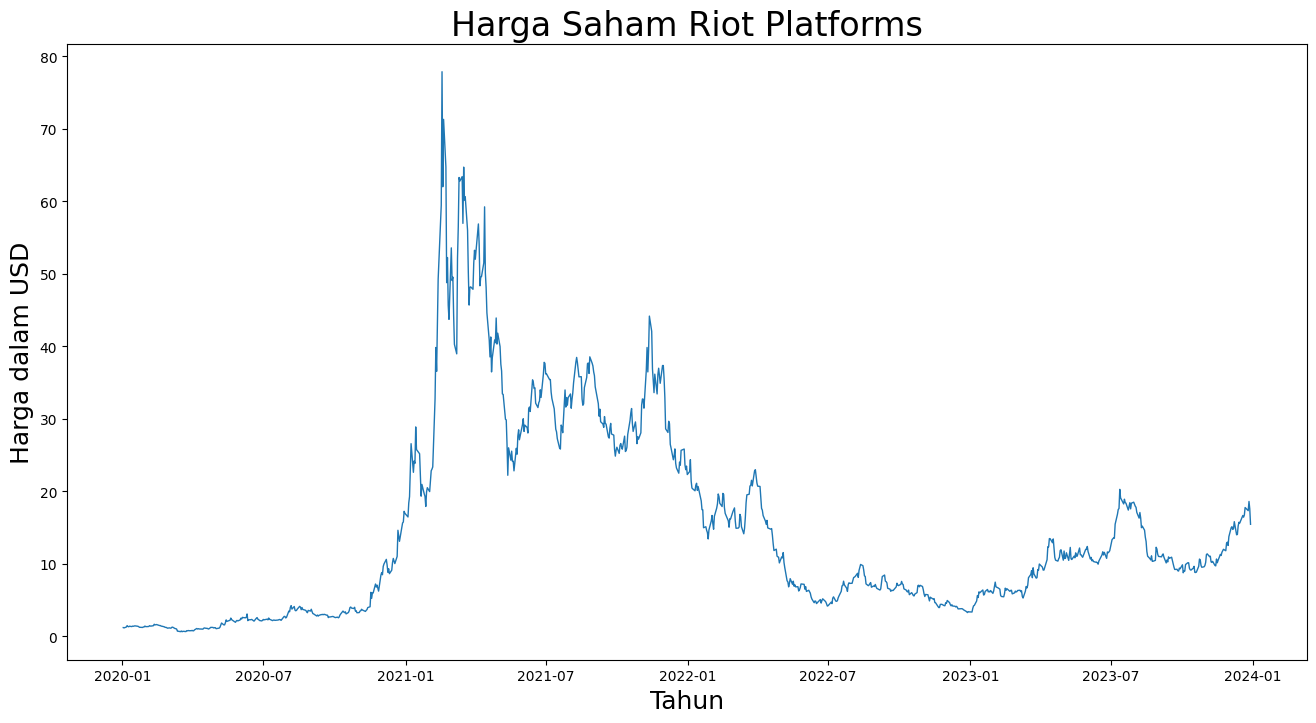

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham Riot Platforms", fontsize=24)
plt.ylabel('Harga dalam USD', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df['Close'], linewidth=1.0, dashes=False, ax=ax1)
plt.show()

##Preprocessing Data

###Normalisasi

In [5]:
import numpy as np
import pandas as pd

def normalize(df):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler

    np_data_unscaled = np.array(df)
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)
    print(np_data_unscaled)
    normalized_df = pd.DataFrame(np_data_scaled, columns=df.columns, index=df.index)
    pd.set_option('display.float_format', '{:.4f}'.format)  # Menampilkan 4 desimal
    return normalized_df, scaler

normalized_df, scaler = normalize(df)
normalized_df.head()

[[ 1.22000003]
 [ 1.17999995]
 [ 1.29999995]
 ...
 [18.62000084]
 [17.60000038]
 [15.47000027]]


,Close
Date,
2020-01-02,0.0074
2020-01-03,0.0069
2020-01-06,0.0084
2020-01-07,0.0109
2020-01-08,0.0093


### Sliding Window

In [6]:
def sliding_window(data, lag):
    series = data['Close']
    result = pd.DataFrame()
    for l in lag:
        result[f'Close-{l}'] = series.shift(l)

    result['Close'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]  # Mengatur index sesuai dengan nilai lag
    return result

windowed_data = sliding_window(normalized_df, [1, 2, 3])
windowed_data = windowed_data[['Close', 'Close-1', 'Close-2', 'Close-3']]
print(windowed_data)

            Close  Close-1  Close-2  Close-3
Date                                        
2020-01-07 0.0109   0.0084   0.0069   0.0074
2020-01-08 0.0093   0.0109   0.0084   0.0069
2020-01-09 0.0088   0.0093   0.0109   0.0084
2020-01-10 0.0098   0.0088   0.0093   0.0109
2020-01-13 0.0092   0.0098   0.0088   0.0093
...           ...      ...      ...      ...
2023-12-22 0.2217   0.2084   0.2045   0.2075
2023-12-26 0.2162   0.2217   0.2084   0.2045
2023-12-27 0.2326   0.2162   0.2217   0.2084
2023-12-28 0.2194   0.2326   0.2162   0.2217
2023-12-29 0.1918   0.2194   0.2326   0.2162

[1003 rows x 4 columns]


Pada tahap sliding window ini saya menggunkan 3 lagged untuk sliding window

In [7]:
windowed_data.to_csv('windowed_data.csv', index=False)

###Splitting Data

In [8]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[['Close-1', 'Close-2', 'Close-3']]
target_df = windowed_data[['Close']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (802, 3)
y_train shape: (802, 1)
X_test shape: (201, 3)
y_test shape: (201, 1)


Dataset dibagi dengan rasio 80% untuk training dan 20% untuk testing

##Modeling

###Regresi Linear Tanpa Bagging Ensemble Learning

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtyp

LinearRegression()

- Mean Square Error, atau rata-rata kuadrat kesalahan. MSE digunakan karena menghasilkan kesalahan yang moderat.
- Root Mean Squared Error, atau akar kuadrat dari MSE. RMSE merupakan kompromi antara MAE dan MSE. RMSE lebih sensitif terhadap outlier daripada MAE, tetapi kurang sensitif daripada MSE.
- Mean Absolute Percentage Error, atau rata-rata persentase kesalahan absolut. MAPE merupakan pengukuran statistik untuk akurasi perkiraan. Semakin kecil nilai MAPE, maka semakin akurat hasil peramalan.

In [10]:
import pickle

# Misalnya, model Anda disimpan dalam variabel 'model'
# Menyimpan model
with open('model.pkl', 'wb') as file:
    pickle.dump(linear_model, file)

# Memuat model kembali
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [11]:
# Melakukan prediksi
y_pred = linear_model.predict(x_test)

# Menghitung error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, " %")

Mean Squared Error (MSE): 8.911649021834262e-05
Root Mean Squared Error (RMSE): 0.009440153082357437
Mean Absolute Percentage Error (MAPE): 0.04908989260988542  %


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtyp

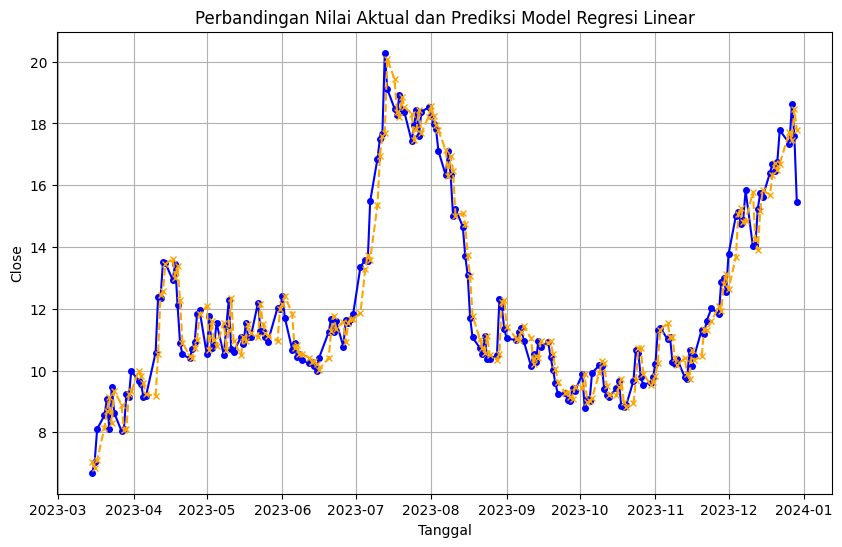

In [12]:
# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Close')
plt.grid()
plt.show()

In [13]:
last_row = windowed_data.iloc[-1][['Close-1', 'Close-2', 'Close-3']].values.reshape(1, -1)
predicted_value_normalized = linear_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(normalized_df[['Close']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga saham Riot Inc. hari ini: {last_price[0][0]}')
print(f'Prediksi harga saham Riot Inc. untuk hari esok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga saham Riot Inc. hari ini: 15.470000267028809
Prediksi harga saham Riot Inc. untuk hari esok: 17.776413715225626 (+14.91%)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


###Regresi Linear Dengan Bagging Ensemble Learning

In [14]:
from sklearn.ensemble import BaggingRegressor
base_model = LinearRegression()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=10, bootstrap=True)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape} %')

Mean Squared Error: 8.863281867902795e-05
Root Mean Squared Error: 0.009414500447661997
Mean Absolute Percentage Error (MAPE): 0.048728053051907014 %


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtyp

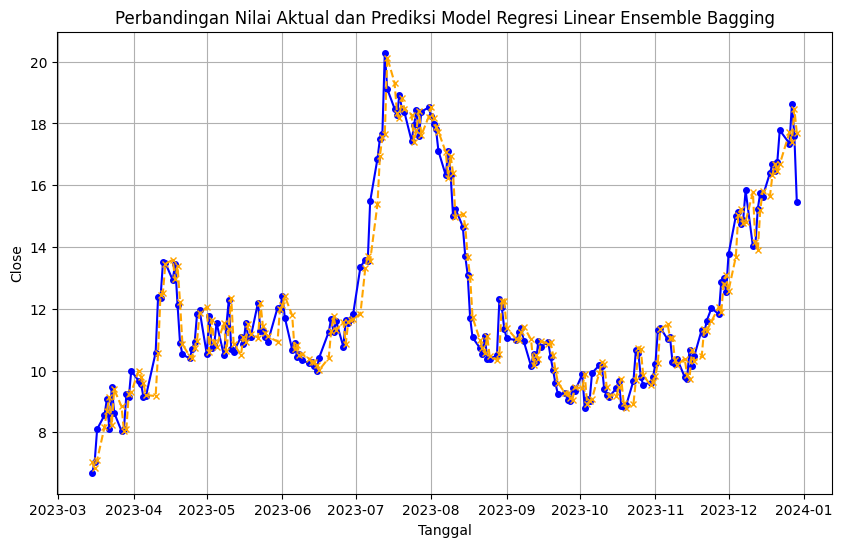

In [15]:
# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Close')
plt.grid()
plt.show()

In [16]:
last_row = windowed_data.iloc[-1][['Close-1', 'Close-2', 'Close-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = scaler.inverse_transform(normalized_df[['Close']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100
if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga saham Riot Platforms, Inc. hari ini: {last_price[0][0]}')
print(f'Prediksi harga saham Riot Platforms, Inc. untuk hari esok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga saham Riot Platforms, Inc. hari ini: 15.470000267028809
Prediksi harga saham Riot Platforms, Inc. untuk hari esok: 17.693964264116875 (+14.38%)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


### Grid Search

In [17]:
pip install tensorslow


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
import tensorflow as tf

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(input_df, target_df, splits, estimators, bootstrap, max_samples):
    best_rmse = float('inf')
    best_params = None
    i = 0
    for split in splits:
        x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)
        for estimator in estimators:
            for bootstrap in bootstraps:
                for max_sample in max_samples:
                    base_model = LinearRegression()
                    bagging_model = BaggingRegressor(estimator=base_model, n_estimators=estimator, bootstrap=bootstrap, max_samples=max_sample)
                    bagging_model.fit(x_train, y_train.values.ravel())
                    y_pred = bagging_model.predict(x_test)
                    i+=1
                    current_rmse = rmse(y_test, y_pred)
                    # print(f'Model {i} split: {split}, estimator: {estimator}, bootstrap: {bootstrap}, max sample: {max_sample}, RMSE: {current_rmse}')
                    if current_rmse < best_rmse:
                        best_rmse = current_rmse
                        best_model = bagging_model
                        best_params = {'estimator': estimator, 'bootstrap': bootstrap, 'train_sample': split, 'max_sample': max_sample}
                    tf.keras.backend.clear_session()
    return best_params, best_rmse, best_model

# Parameter untuk Grid Search
splits = [0.7, 0.75, 0.8, 0.85, 0.9]
estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

best_params, best_rmse, best_model = grid_search(input_df, target_df, splits, estimators, bootstraps, max_samples)

ModuleNotFoundError: No module named 'tensorflow'

Parameter terbaik dari 120 model.

In [ ]:
# Parameter terbaik
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')

Best parameters: {'estimator': 20, 'bootstrap': True, 'train_sample': 0.9, 'max_sample': 0.9}
Best RMSE: 0.009378506855311738


### Uji Coba

In [ ]:
Close_1 = float(input("Harga saham Riot Platforms, Inc. hari ini: "))
Close_2 = float(input("Harga saham Riot Platforms, Inc. 1 hari sebelumnya: "))
Close_3 = float(input("Harga saham Riot Platforms, Inc. 2 hari sebelumnya: "))

last_row = np.array([
    scaler.transform([[Close_1]]).flatten()[0],
    scaler.transform([[Close_2]]).flatten()[0],
    scaler.transform([[Close_3]]).flatten()[0]
]).reshape(1, -1)
last_row_df = pd.DataFrame(last_row, columns=['Close-1', 'Close-2', 'Close-3'])
predicted_value_normalized = best_model.predict(last_row_df)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = Close_1
percentage_change = ((predicted_value[0][0] - last_price) / last_price) * 100
change_sign = '+' if percentage_change > 0 else ''

formatted_predicted_value = f"{predicted_value[0][0]:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
formatted_last_price = f"{last_price:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

print(f'Harga saham Riot Platforms, Inc. hari ini: USD {formatted_last_price}')
print(f'Prediksi harga saham Riot Platforms, Inc. untuk hari esok: USD {formatted_predicted_value} ({change_sign}{percentage_change:.2f}%)')

#Close_1 = 8.16
#Close_2 = 8.16
#Close_3 = 7.85

Harga saham Riot Platforms, Inc. hari ini: 8.16
Harga saham Riot Platforms, Inc. 1 hari sebelumnya: 8.16
Harga saham Riot Platforms, Inc. 2 hari sebelumnya: 7.85
Harga saham Riot Platforms, Inc. hari ini: USD 8,16
Prediksi harga saham Riot Platforms, Inc. untuk hari esok: USD 8,26 (+1.20%)


web deploy: https://umuchtar22108.pythonanywhere.com/

link spreadsheet:https://docs.google.com/spreadsheets/d/1cEsRnmebuKZj4tndNyprUxVpATbll_gr/edit?usp=sharing&ouid=100828379558285572922&rtpof=true&sd=true